## Discriminate Gender using the BioSound decompostion of the Baby Cries from Mathevon

### Firs read all the h5 files and generate a summary table in Pandas.

In [1]:
from soundsig.sound import BioSound 
import os
import pandas
import numpy as np
from soundsig.discriminate import discriminatePlot

%matplotlib inline


# Read the matlab file that has all the cut sounds
os.chdir('/Users/frederictheunissen/Documents/Data/Babies/Banque Pleurs Francais originaux full /h5files')
store = '/Users/frederictheunissen/Documents/Data/Babies/Banque Pleurs Francais originaux full /vocSelTable.h5'

nfiles = len([fname for fname in os.listdir('.') if fname.endswith('h5')])

# Allocate space for fundamental, cvfund, formants, saliency, rms, spectral means, std, q1, q2, q3, time std
# Trying a list of dictionaries
vocSelData = []

for fname in os.listdir('.'):
    if fname.endswith('.h5'):
        myBioSound = BioSound()
        myBioSound.readh5(fname)
        meanF1 = np.mean(myBioSound.F1[~np.isnan(myBioSound.F1)])
        meanF2 = np.mean(myBioSound.F2[~np.isnan(myBioSound.F2)])
        meanF3 = np.mean(myBioSound.F3[~np.isnan(myBioSound.F3)])
        Baby = np.array2string(myBioSound.emitter).translate(None, "'")[6:]

        
        callType = np.array2string(myBioSound.type).translate(None, "'")
        
        if myBioSound.fund is not None:
            fund = np.float(myBioSound.fund)
            cvfund = np.float(myBioSound.cvfund)
        else:
            fund = None 
            cvfund = None   

        vocSelData.append({"Baby": Baby, "calltype": callType, "fund": fund, 
                     "cvfund": cvfund, "F1": meanF1, "F2": meanF2, "F3":meanF3,
                     "sal": np.float(myBioSound.sal), "rms": np.float(myBioSound.rms), 
                     "meanS": np.float(myBioSound.meanspect), "stdS": np.float(myBioSound.stdspect), 
                     "q1": np.float(myBioSound.q1), "q2": np.float(myBioSound.q2), "q3": np.float(myBioSound.q3),
                     "timestd": np.float(myBioSound.stdtime),
                    "mps": np.reshape(myBioSound.mps,-1)})

# Make two data frames one with all the data and one grouped by Baby and calltype                    
vocSelTable = pandas.DataFrame(vocSelData)
vocSelTable.to_hdf(store, 'babyTable', mode = 'w')




/Users/frederictheunissen/anaconda/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/Users/frederictheunissen/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/frederictheunissen/anaconda/lib/python2.7/site-packages/pandas/core/generic.py:1471: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [in

### Classifier for Gender

Variance explained is 100.00%
LDA Weights:
DFA 0: C5 7.203; C3 -0.513; C2 -0.003; C0 0.002; C4 -0.002; 


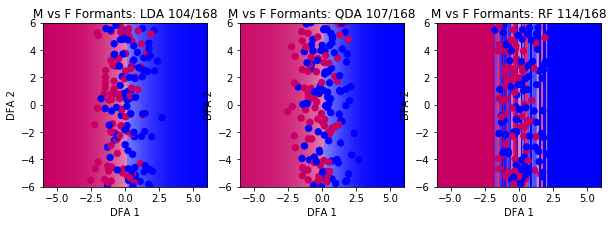

Number of classes 2. Chance level 50.00 %
M vs F Formants LDA: 61.90 % (104/168 p=0.0013)
M vs F Formants QDA: 63.69 % (107/168 p=0.0002)
M vs F Formants RF: 67.86 % (114/168 p=0.0000)
Variance explained is 100.00%
LDA Weights:
DFA 0: C5 6.889; C3 -1.187; C4 -0.002; C1 0.001; C2 -0.001; 


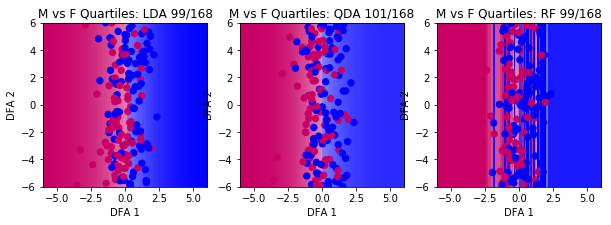

Number of classes 2. Chance level 50.00 %
M vs F Quartiles LDA: 58.93 % (99/168 p=0.0125)
M vs F Quartiles QDA: 60.12 % (101/168 p=0.0053)
M vs F Quartiles RF: 58.93 % (99/168 p=0.0125)
Variance explained is 87.85%
LDA Weights:
DFA 0: C9544 0.000; C9948 0.000; C9847 0.000; C9645 0.000; C7928 -0.000; 


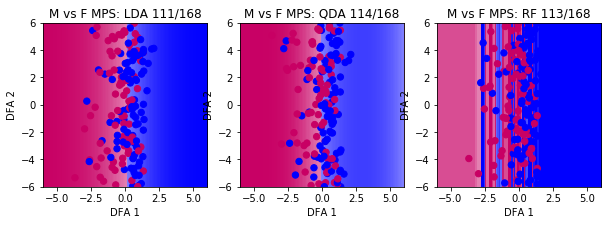

Number of classes 2. Chance level 50.00 %
M vs F MPS LDA: 66.07 % (111/168 p=0.0000)
M vs F MPS QDA: 67.86 % (114/168 p=0.0000)
M vs F MPS RF: 67.26 % (113/168 p=0.0000)


In [4]:
vocSelTableGrouped = vocSelTable.groupby(['Baby','calltype'])
vocSelTableGroupedAgg = vocSelTableGrouped.aggregate(np.mean).reset_index()


# Color code for call type
callColor = {'F': (200/255.0, 0/255.0, 100/255.0), 'M': (0/255.0, 0/255.0, 255/255.0)}

callTypes = np.unique(vocSelTableGroupedAgg['calltype'])

# This is for grouped data
cVal = []
for cType in vocSelTableGroupedAgg['calltype']:
    cVal.append(callColor[cType])
cVal = np.asarray(cVal) 
  
# This is for all data  
cVal = []
for cType in vocSelTable['calltype']:
    cVal.append(callColor[cType])
cVal = np.asarray(cVal) 
    
# Perform some classifications averaged by baby.
# Formants + Fund Model   
# X = np.array([vocSelTableGroupedAgg['F1'], vocSelTableGroupedAgg['F2'], vocSelTableGroupedAgg['F3'], vocSelTableGroupedAgg['sal'], vocSelTableGroupedAgg['fund'], vocSelTableGroupedAgg['cvfund']])
# y = np.array(vocSelTableGroupedAgg['calltype'])

X = np.array([vocSelTable['F1'], vocSelTable['F2'], vocSelTable['F3'], vocSelTable['sal'], vocSelTable['fund'], vocSelTable['cvfund']])
y = np.array(vocSelTable['calltype'])
ldaYes, qdaYes, rfYes, cvCount, ldaP, qdaP, rfP, nClasses, weights = discriminatePlot(X.transpose(), y, cVal, titleStr='M vs F Formants', plotFig = True)

# Quartiles + Fund.
# X = np.array([vocSelTableGroupedAgg['q1'], vocSelTableGroupedAgg['q2'], vocSelTableGroupedAgg['q3'], vocSelTableGroupedAgg['sal'], vocSelTableGroupedAgg['fund'], vocSelTableGroupedAgg['cvfund']])
# y = np.array(vocSelTableGroupedAgg['calltype'])

X = np.array([vocSelTable['q1'], vocSelTable['q2'], vocSelTable['q3'], vocSelTable['sal'], vocSelTable['fund'], vocSelTable['cvfund']])
y = np.array(vocSelTable['calltype'])
ldaYes, qdaYes, rfYes, cvCount, ldaP, qdaP, rfP, nClasses, weights = discriminatePlot(X.transpose(), y, cVal, titleStr='M vs F Quartiles', plotFig = True)

# MPS.
X = np.stack(vocSelTable['mps'])
y = np.array(vocSelTable['calltype'])
cVal = []
for cType in vocSelTable['calltype']:
    cVal.append(callColor[cType])
cVal = np.asarray(cVal) 

ldaYes, qdaYes, rfYes, cvCount, ldaP, qdaP, rfP, nClasses, weights= discriminatePlot(X, y, cVal, titleStr='M vs F MPS', plotFig = True)